In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [50]:
data = pd.read_csv('data/data.csv')

In [51]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [52]:
list(data.columns.values)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

# Notes

* Can we improve the missing data strategy?
* Are all the limitations to algorithm application verified?

* prevent leakage: train only on shots prior to the ones we're predicting (year)
* select features and then explore number of neighbours

* target: score=0.75

# Preprocessing

In [53]:
# TRAINING AND TEST DATA
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0)

In [54]:
# MISSING DATA
# don't consider rows with shot_made_flag = NaN
train_data = train_data[np.isfinite(train_data['shot_made_flag'])]
test_data = test_data[np.isfinite(test_data['shot_made_flag'])]

# Engineering features

### Shots by opponent

In [55]:
total_shots = pd.pivot_table(data, index="opponent", values="shot_id", aggfunc='count')

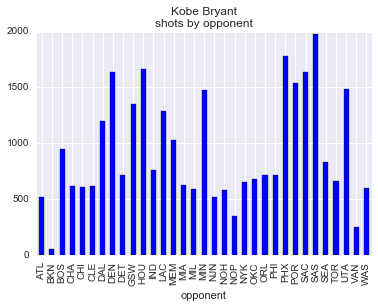

In [56]:
total_shots.plot.bar(title='Kobe Bryant\nshots by opponent')

### Shots by distance

In [57]:
total_distance = pd.pivot_table(data, index="shot_distance", values="shot_id", aggfunc='count')

[0, 30, 0, 6000]

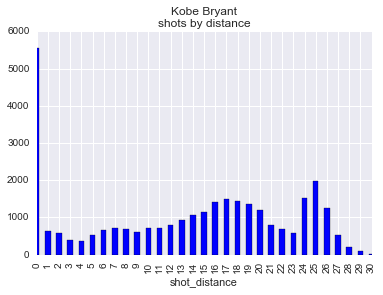

In [83]:
total_distance.plot.bar(title='Kobe Bryant\nshots by distance')
plt.axis([0, 30, 0, 6000])

### Minutes remaining

In [86]:
minutes = pd.pivot_table(data, index="minutes_remaining", values="shot_id", aggfunc='count')

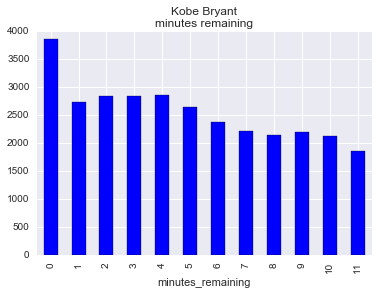

In [88]:
minutes.plot.bar(title='Kobe Bryant\nminutes remaining')

### Seconds remaining

In [89]:
seconds = pd.pivot_table(data, index="seconds_remaining", values="shot_id", aggfunc='count')

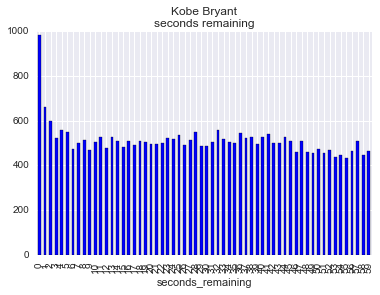

In [92]:
seconds.plot.bar(title='Kobe Bryant\nseconds remaining')

### Shots by zone range

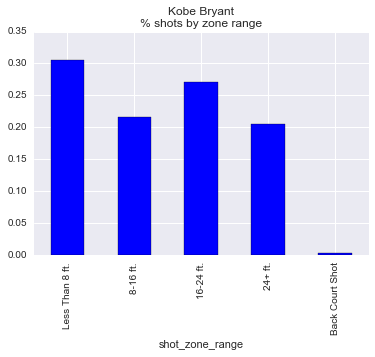

In [60]:
shot_zones = pd.pivot_table(data, index="shot_zone_range", values="shot_id", aggfunc='count')
shot_zones_pct = shot_zones/shot_zones.sum()

# change order
shot_zones_pct = shot_zones_pct.reindex(index=['Less Than 8 ft.',  u'8-16 ft.', u'16-24 ft.', u'24+ ft.', u'Back Court Shot'])
shot_zones_pct.plot.bar(title='Kobe Bryant\n% shots by zone range')

# 1. kNN

** References: **
* http://scikit-learn.org/stable/modules/neighbors.html
* http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1784392774/ref=sr_1_1?ie=UTF8&qid=1461733493&sr=8-1&keywords=luis+pedro+coelho+python

In [61]:
from sklearn import neighbors

In [62]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2)

In [63]:
x1 = train_data['loc_x'].reshape(len(train_data['loc_x']),1)
x2 = train_data['loc_y'].reshape(len(train_data['loc_y']),1)
x3 = train_data['shot_distance'].reshape(len(train_data['shot_distance']),1)

In [64]:
x = np.concatenate((x1,x2,x3), axis=1)
y = train_data['shot_made_flag'].reshape(len(train_data['shot_made_flag']),1)

print x.shape
print y.shape

(20550L, 3L)
(20550L, 1L)


In [65]:
knn.fit(x,y.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [66]:
#knn.predict([0])

In [67]:
#knn.predict_proba([0])

## 1.1 kNN evaluation

In [68]:
x1_test = test_data['loc_x'].reshape(len(test_data['loc_x']),1)
x2_test = test_data['loc_y'].reshape(len(test_data['loc_y']),1)
x3_test = test_data['shot_distance'].reshape(len(test_data['shot_distance']),1)

In [69]:
x_test = np.concatenate((x1_test,x2_test,x3_test), axis=1)
y_test = test_data['shot_made_flag'].reshape(len(test_data['shot_made_flag']),1)

In [70]:
knn.score(x_test,y_test)

0.57159510394404511